In [27]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGE = True

In [28]:
species = pd.read_csv('../input/monkey_labels.txt')
species

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


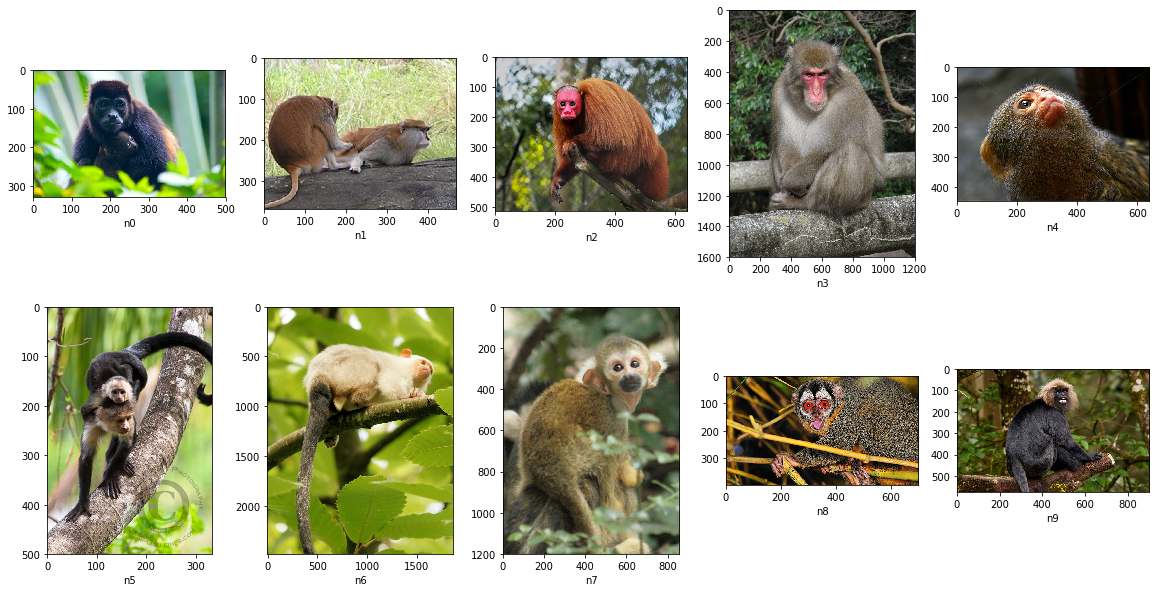

In [29]:
#  Visualizing Data
plt.figure(figsize = (20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    class_name = 'n' + str(i)
    plt.imshow(plt.imread('../input/validation/validation/' + class_name + '/' + class_name + '00.jpg'))
    plt.xlabel(class_name)

In [30]:
no_classes = 10
epoch = 15
patient = 5
train_dir = '../input/training/training/'
val_dir = '../input/validation/validation/'
Model_Check_Weight_Name = 'resnet.h5'

In [31]:
K.set_learning_phase(0)
resnet = ResNet50(input_shape = (224,224,3),include_top = False, weights = 'imagenet', pooling = 'avg')
K.set_learning_phase(1)
x = resnet.output
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(no_classes, activation = 'softmax', name = 'custom_output')(x)
model = Model(inputs = resnet.input, outputs = output)

for layer in resnet.layers:
    layer.trainable = False

model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [32]:
#  Data Augmentation
#  Height Shift
#  Width Shift
#  Flipping
aug_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input,
                                              horizontal_flip = True,
                                              rotation_range = 20,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2)

notaug_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [33]:
#datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = aug_data_generator.flow_from_directory(train_dir, target_size = (224,224), batch_size = 32, class_mode = 'categorical')
validation_generator = notaug_data_generator.flow_from_directory(val_dir, target_size = (224,224), batch_size = 32, class_mode = 'categorical', shuffle=False)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [34]:
#  Using ModelCheckpoint to save the Best Model based on Validation Accuracy
es_callback = EarlyStopping(monitor = 'val_acc', patience = patient, mode = 'max')
mc_callback = ModelCheckpoint(filepath = Model_Check_Weight_Name, monitor = 'val_acc', save_best_only = True, mode = 'max')

In [35]:
model_history = model.fit_generator(train_generator, steps_per_epoch = len(train_generator), epochs = epoch, validation_data = train_generator, validation_steps = len(validation_generator), verbose = 2, callbacks = [es_callback, mc_callback])

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 51s - loss: 1.5254 - acc: 0.5185 - val_loss: 0.5773 - val_acc: 0.7917
Epoch 2/15
 - 26s - loss: 0.3429 - acc: 0.8910 - val_loss: 0.3345 - val_acc: 0.9167
Epoch 3/15
 - 43s - loss: 0.2504 - acc: 0.9165 - val_loss: 0.2179 - val_acc: 0.9306
Epoch 4/15
 - 44s - loss: 0.1757 - acc: 0.9401 - val_loss: 0.1739 - val_acc: 0.9472
Epoch 5/15
 - 41s - loss: 0.1257 - acc: 0.9553 - val_loss: 0.1343 - val_acc: 0.9514
Epoch 6/15
 - 44s - loss: 0.1588 - acc: 0.9437 - val_loss: 0.2695 - val_acc: 0.9375
Epoch 7/15
 - 44s - loss: 0.1704 - acc: 0.9455 - val_loss: 0.1204 - val_acc: 0.9514
Epoch 8/15
 - 41s - loss: 0.1424 - acc: 0.9513 - val_loss: 0.1536 - val_acc: 0.9358
Epoch 9/15
 - 43s - loss: 0.1260 - acc: 0.9669 - val_loss: 0.0843 - val_acc: 0.9722
Epoch 10/15
 - 44s - loss: 0.1277 - acc: 0.9607 - val_loss: 0.0910 - val_acc: 0.9618
Epoch 11/15
 - 43s - loss: 0.0799 - acc: 0.9804 - val_loss: 0.0671 - val_acc: 0.9826
Epoch 12/15
 - 42s - loss:

In [ ]:
history = pd.DataFrame()
history["acc"] = model_history.history["acc"]
history["val_acc"] = model_history.history["val_acc"]
history.plot(figsize = (12, 6))

In [ ]:
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training & Validation Accuracy')
plt.plot(epochs, acc, 'blue', label='Training Acc')
plt.plot(epochs, val_acc, 'red', label='Validation Acc')
plt.legend()

plt.figure()
plt.title('Training & Validation Loss')
plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'red', label='Validation Loss')

plt.legend()

plt.show()

In [ ]:
#  Loading Last Checkpoint Weight
model.load_weights(Model_Check_Weight_Name)

In [ ]:
#  Printing Validation Confusion Matrix, Classification Report, & Accuracy
predict = model.predict_generator(validation_generator, steps = len(validation_generator), verbose = 1)
test_labels = validation_generator.classes
confusion_matrix(test_labels, predict.argmax(axis = 1))

In [ ]:
labels = list(validation_generator.class_indices.keys())
classification_report(test_labels, predict.argmax(axis = 1), target_names = labels)

In [ ]:
accuracy_score(test_labels,predict.argmax(axis = 1))